<a href="https://colab.research.google.com/github/james-cranley/gcolab/blob/main/tavi_ppm_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Useful Resources

Chapter 9 R4HDS (LR modelling) https://argoshare.is.ed.ac.uk/healthyr_book/chap09-h1.html

Code for evaluating LR models https://raw.githubusercontent.com/easonfg/cali_tutorial

LinkedIn Learning Video on modelling https://www.linkedin.com/learning/healthcare-analytics-regression-in-r/overview-of-modeling-process?u=2963594


# Prepare environment and load packages

In [2]:
# Mount the drive

from google.colab import drive
drive.mount('/content/gdrive')

# Will need the auth code

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Prepare R in Python
%load_ext rpy2.ipython

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [7]:
# Set WD

%%R

wd <- '/content/gdrive/MyDrive/Colab Notebooks/tavi_ppm'
setwd(wd)

In [ ]:
# Install packages (this can take a few minutes)
%%R

install.packages('caret')
install.packages('glmnet')
install.packages('arm')
install.packages('broom')
install.packages('lars')
install.packages('GGally')
install.packages('googlesheets4')

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘iterators’, ‘data.table’, ‘gower’, ‘ipred’, ‘timeDate’, ‘foreach’, ‘plyr’, ‘ModelMetrics’, ‘reshape2’, ‘recipes’, ‘pROC’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/numDeriv_2016.8-1.1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 76053 bytes (74 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to c

In [8]:
# Load packages
%%R

library(glmnet)
library(tidyverse)
library(caret)
library(arm)
library(broom)
library(lars)
library(GGally)
library(googlesheets4)

R[write to console]: Error in library(glmnet) : there is no package called ‘glmnet’
Calls: <Anonymous> -> <Anonymous> -> withVisible -> library




Error in library(glmnet) : there is no package called ‘glmnet’
Calls: <Anonymous> -> <Anonymous> -> withVisible -> library


# Load in data

In [ ]:
# Load in data from csv
%%R

master <- read.csv('/content/drive/MyDrive/Colab Notebooks/tavi_ppm/data/tavi_all.csv')
str(master)

'data.frame':	304 obs. of  22 variables:
 $ age                 : int  79 85 84 80 85 83 78 71 70 88 ...
 $ sex                 : chr  "F" "M" "F" "M" ...
 $ proc.date           : chr  "12.02.20" "11.02.20" "11.02.20" "11.02.20" ...
 $ pre.pri             : chr  "AF" "122" "AF" "160" ...
 $ pre.af              : int  1 0 1 0 0 1 0 0 0 0 ...
 $ pre.qrsd            : int  94 90 104 100 94 132 84 118 86 91 ...
 $ pre.qrsm            : chr  "normal" "incomplete LBBB" "incomplete LBBB" "normal" ...
 $ intra.valve.type    : chr  "Edwards S3" "Edwards S3" "Edwards S3" "CoreValve Evolut PRO" ...
 $ intra.valve.size    : int  23 26 26 26 29 23 26 23 34 23 ...
 $ intra.anatomy       : chr  "none" "none" "none" "none" ...
 $ intra.avb.presence  : chr  "N" "N" "N" "N" ...
 $ intra.avb.type      : chr  "/" "/" "/" "/" ...
 $ post.monitoring.days: chr  "4" "2" "2" "2" ...
 $ post.avb.presence   : chr  "N" "N" "N" "N" ...
 $ post.avb.type       : chr  "/" "/" "/" "/" ...
 $ post.pri            : chr 

In [9]:
# Read in data from gsheet
%%R

master <- read_sheet('https://docs.google.com/spreadsheets/d/1tBVpu7LHj2RcsqJljRAqvSouM55mSlfGDsvpsXtnfLI/edit?usp=sharing')

R[write to console]: Error in read_sheet("https://docs.google.com/spreadsheets/d/1tBVpu7LHj2RcsqJljRAqvSouM55mSlfGDsvpsXtnfLI/edit?usp=sharing") : 
  could not find function "read_sheet"
Calls: <Anonymous> -> <Anonymous> -> withVisible




Error in read_sheet("https://docs.google.com/spreadsheets/d/1tBVpu7LHj2RcsqJljRAqvSouM55mSlfGDsvpsXtnfLI/edit?usp=sharing") : 
  could not find function "read_sheet"
Calls: <Anonymous> -> <Anonymous> -> withVisible


In [ ]:
# Inspect gsheet
%%R

str(master)

# Inspect data for correlations

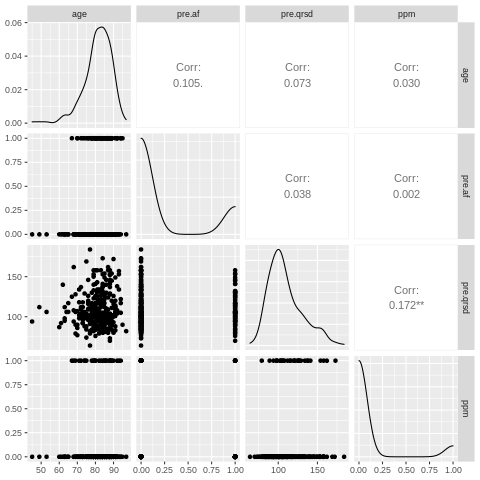

In [ ]:
# ggpairs is good for this
# https://www.linkedin.com/learning/r-essential-training-part-2-modeling-data/predicting-outcomes-with-quantile-regression?u=2963594

%%R

df <- master[ , c("age", "pre.af", "pre.qrsd", "ppm")]
df %>% ggpairs()

# Make a non penalised LR model using glm

In [ ]:
# Make a non penalised LR model with all variables

%%R
model_data <- df
LR1 <- glm(data = model_data, ppm~., family = 'binomial')
summary(LR1)


Call:
glm(formula = ppm ~ ., family = "binomial", data = model_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9355  -0.4711  -0.4053  -0.3505   2.4894  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)   
(Intercept) -5.362460   2.316521  -2.315  0.02062 * 
age          0.007379   0.026987   0.273  0.78453   
pre.af      -0.016261   0.460191  -0.035  0.97181   
pre.qrsd     0.022797   0.007961   2.864  0.00419 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 200.27  on 303  degrees of freedom
Residual deviance: 192.07  on 300  degrees of freedom
AIC: 200.07

Number of Fisher Scoring iterations: 5



In [ ]:
# Make a results table for LR1
%%R

LR1res <- tidy(LR1)
LR1res <- LR1res %>% mutate(OR = exp(estimate))
LR1res <- LR1res %>% mutate(UCI = OR + 1.96*(exp(std.error)))
LR1res <- LR1res %>% mutate(LCI = OR - 1.96*(exp(std.error)))
LR1res

# NB The 95% CI would be exp(OR +/- (1.96 * SE))
# If 95% CI crosses 1 then the OR is not significant

# A tibble: 4 x 8
  term        estimate std.error statistic p.value      OR   UCI     LCI
  <chr>          <dbl>     <dbl>     <dbl>   <dbl>   <dbl> <dbl>   <dbl>
1 (Intercept) -5.36      2.32      -2.31   0.0206  0.00469 19.9  -19.9  
2 age          0.00738   0.0270     0.273  0.785   1.01     3.02  -1.01 
3 pre.af      -0.0163    0.460     -0.0353 0.972   0.984    4.09  -2.12 
4 pre.qrsd     0.0228    0.00796    2.86   0.00419 1.02     3.00  -0.953


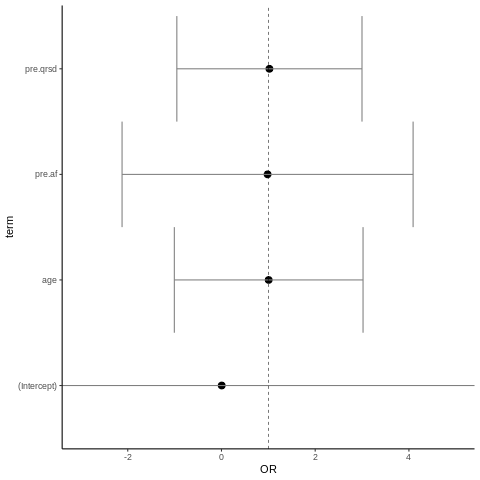

In [ ]:
# Odds Ratio Plot for LR1

%%R

LR1res %>% ggplot() +
geom_point(aes(x = OR, y = term),
           size = 3) +
geom_errorbarh(aes(y = term, xmin = LCI, xmax = UCI),
               size = .5,
               height = 1,
               color = "gray50") +
coord_cartesian(xlim = c(-3, 5)) +
geom_vline(aes(xintercept = 1), size = .25, linetype = "dashed") +
theme_classic()

# LASSO Regression

In [ ]:
# LASSO regression
# Works best if values are similar therefore scale to mean 0 SD 1 using scale() - makes a Z score
# https://www.linkedin.com/learning/r-essential-training-part-2-modeling-data/predicting-outcomes-with-lasso-regression?u=2963594

%%R

model_data <- master
model_data <- model_data %>% scale()

# Lars likes input and outputs as different matrices
y <- as.matrix(model_data[ , c(41)])
X <- as.matrix(model_data[ , c(2:40)]) # Capital X becuase several variables

In [ ]:
# Lasso regression
%%R

fit_lasso <- lars(X, y, type = "lasso")

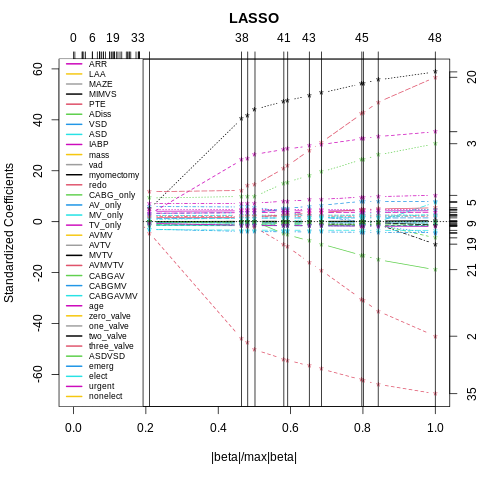

In [ ]:
# Plot the results

%%R

fit_lasso %>% plot()
legend(
    "bottomleft",
    lwd = 2,
    col = (1:nrow(X)),
    legend = colnames(X),
    cex = .7
)

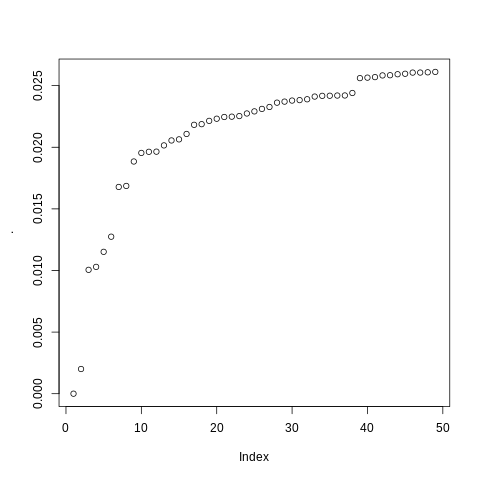

In [ ]:
# View R squared
%%R

fit_lasso$R2
fit_lasso$R2 %>% plot()

In [ ]:
# Get coefficients at each step
%%R
fit_lasso %>% coef()
fit_lasso


Call:
lars(x = X, y = y, type = "lasso")
R-squared: 0.026 
Sequence of LASSO moves:
     zero_valve one_valve TV AVTV CABG_only AV redo MV ARR age MAZE CABG
Var          31       -32  4   24        19  2   18  3   6  30    8    5
Step          1         1  2    3         4  5    6  7   8   9   10   11
     myomectomy CABG_only IABP emerg mass ADiss LAA urgent ASD AVMVTV
Var          17       -19   14    36   15    11   7     38  13     26
Step         12        13   14    15   16    17  18     19  20     21
     three_valve PTE TV_only elect AV_only VSD CABGAVMV emerg vad MIMVS CABGMV
Var          -34  10      22    37      20  12       29   -36  16     9     28
Step          21  22      23    24      25  26       27    28  29    30     31
     AV nonelect AVMV CABGAV SEX ASDVSD zero_valve AV AVMV MV_only AVMV
Var  -2       39   23     27   1     35        -31  2  -23      21   23
Step 32       33   34     35  36     37         38 39   40      41   42
     zero_valve CABG_only CABG TV

In [ ]:
%%R


R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependency ‘reshape’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/reshape_0.8.8.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 42558 bytes (41 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to co

# Forward Stepwise

In [ ]:
# Refine Model
# Strip it back to significant predictors

%%R

model_data <- read.csv('/content/drive/MyDrive/Colab Notebooks/surgery_ppm/data/md_all.csv')
model_data <- model_data[ ,c("age", "MV", "MAZE", "redo", "myomectomy", "AVTV", "zero_valve", "elect", "urgent","ppm")]
str(model_data)

'data.frame':	19627 obs. of  10 variables:
 $ age       : int  80 76 68 63 80 88 67 66 70 85 ...
 $ MV        : int  0 0 0 1 0 0 0 0 0 0 ...
 $ MAZE      : int  0 1 0 0 0 0 0 0 0 0 ...
 $ redo      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ myomectomy: int  0 0 0 0 0 0 0 0 0 0 ...
 $ AVTV      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ zero_valve: int  0 1 1 0 0 0 1 1 0 0 ...
 $ elect     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ urgent    : int  0 1 1 1 1 0 0 1 1 1 ...
 $ ppm       : int  0 0 0 0 1 0 0 0 0 0 ...


In [ ]:
# Make a model (LR2) using only significant variables

%%R

LR2 <- glm(data = model_data, ppm~., family = 'binomial')
summary(LR2)


Call:
glm(formula = ppm ~ ., family = "binomial", data = model_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1231  -0.3077  -0.2101  -0.1766   3.0657  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.816244   0.275573 -13.848  < 2e-16 ***
age          0.012537   0.003562   3.519 0.000433 ***
MV           0.308331   0.093419   3.301 0.000965 ***
MAZE         0.569717   0.211077   2.699 0.006953 ** 
redo         0.727270   0.137282   5.298 1.17e-07 ***
myomectomy   0.965898   0.483089   1.999 0.045563 *  
AVTV         3.357171   0.570117   5.889 3.90e-09 ***
zero_valve  -1.026658   0.094879 -10.821  < 2e-16 ***
elect       -0.300909   0.134147  -2.243 0.024888 *  
urgent      -0.223152   0.088043  -2.535 0.011258 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5829.2  on 19626  degrees of freedom
Residual deviance: 5554.5

In [ ]:
# Make a results table for LR2
%%R

LR2res <- tidy(LR2)
LR2res <- LR2res %>% mutate(OR = exp(estimate))
LR2res <- LR2res %>% mutate(UCI = OR + 1.96*(exp(std.error)))
LR2res <- LR2res %>% mutate(LCI = OR - 1.96*(exp(std.error)))
LR2res

# A tibble: 10 x 8
   term        estimate std.error statistic  p.value      OR   UCI    LCI
   <chr>          <dbl>     <dbl>     <dbl>    <dbl>   <dbl> <dbl>  <dbl>
 1 (Intercept)  -3.82     0.276      -13.8  1.30e-43  0.0220  2.60 -2.56 
 2 age           0.0125   0.00356      3.52 4.33e- 4  1.01    2.98 -0.954
 3 MV            0.308    0.0934       3.30 9.65e- 4  1.36    3.51 -0.791
 4 MAZE          0.570    0.211        2.70 6.95e- 3  1.77    4.19 -0.653
 5 redo          0.727    0.137        5.30 1.17e- 7  2.07    4.32 -0.179
 6 myomectomy    0.966    0.483        2.00 4.56e- 2  2.63    5.80 -0.550
 7 AVTV          3.36     0.570        5.89 3.90e- 9 28.7    32.2  25.2  
 8 zero_valve   -1.03     0.0949     -10.8  2.74e-27  0.358   2.51 -1.80 
 9 elect        -0.301    0.134       -2.24 2.49e- 2  0.740   2.98 -1.50 
10 urgent       -0.223    0.0880      -2.53 1.13e- 2  0.800   2.94 -1.34 


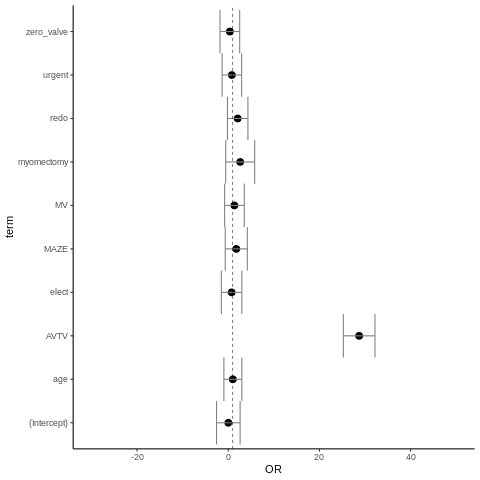

In [ ]:
# Odds Ratio Plot for LR1

%%R

LR2res %>% ggplot() +
geom_point(aes(x = OR, y = term),
           size = 3) +
geom_errorbarh(aes(y = term, xmin = LCI, xmax = UCI),
               size = .5,
               height = 1,
               color = "gray50") +
coord_cartesian(xlim = c(-30, 50)) +
geom_vline(aes(xintercept = 1), size = .25, linetype = "dashed") +
theme_classic()

In [ ]:
#Split into Test and Train sets

%%R

set.seed(123)
trainIndex <- createDataPartition(model_data$ppm, p = .6, 
                                  list = FALSE, 
                                  times = 1)
train_set <- model_data[ trainIndex,]
test_set  <- model_data[-trainIndex,]

In [ ]:
# Make Matrices for GLMNET

%%R

# Dummy code categorical predictor variables
x <- model.matrix(ppm~., train_set)[,-1]

# Convert the outcome (class) to a numerical variable
y <- as.numeric(train_set$ppm)-1

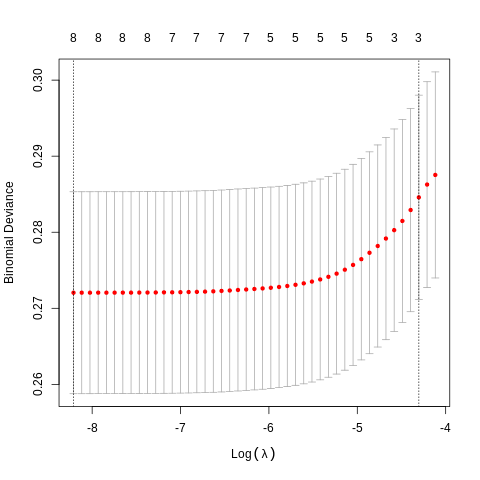

In [ ]:
# Plot make and plot LASSO
%%R

set.seed(123)
cv.lasso <- cv.glmnet(x, y, alpha = 1, family = "binomial")
plot(cv.lasso)

In [ ]:
# Coefficients of LASSO model

%%R

cv.lasso$lambda.min
coef(cv.lasso, cv.lasso$lambda.min)

cv.lasso$lambda.1se
coef(cv.lasso, cv.lasso$lambda.1se)

9 x 1 sparse Matrix of class "dgCMatrix"
                      1
(Intercept) -3.40189292
SEX          .         
AV           0.05296202
MV           .         
TV           0.44201418
CABG         .         
redo         .         
CABG_only   -0.04876568
two_valve    .         


In [ ]:
# Model with lambda.min

%%R

lasso.model <- glmnet(x, y, alpha = 1, family = "binomial",
                      lambda = cv.lasso$lambda.min)

In [ ]:
# Make predictions using test data

%%R

# Make prediction on test data
x.test <- model.matrix(ppm ~., test_set)[,-1]
probabilities <- lasso.model %>% predict(newx = x.test)
predicted.classes <- ifelse(probabilities > 0.5, "pos", "neg")

In [ ]:
# Model accuracy

%%R

observed.classes <- test_set$ppm
mean(predicted.classes == observed.classes)

[1] 0


In [ ]:
#Test Lasso Model

%%R


x.test <- model.matrix(ppm ~., test_set)[,-1]
pred <- lasso.model %>% predict(newx = x.test)
pred_y <- as.numeric(pred>0)
true_y <- as.numeric(test_set$ppm == 1)
true_pos <- (true_y==1) & (pred_y==1)
true_neg <- (true_y==0) & (pred_y==0)
false_pos <- (true_y==0) & (pred_y==1)
false_neg <- (true_y==1) & (pred_y==0)
conf_mat <- matrix(c(sum(true_pos), sum(false_pos),
                     sum(false_neg), sum(true_neg)), 2, 2)
colnames(conf_mat) <- c('Yhat = 1', 'Yhat = 0')
rownames(conf_mat) <- c('Y = 1', 'Y = 0')
conf_mat

#Sensitivity - how good is the model at predicting a positive outocme (i.e. PPM needed). (the proportion of 1s it correctly identifies)
conf_mat[1, 1] / sum(conf_mat[1, ])
#Specificity - how good is the model at predicting a negative outocme (i.e. PPM not needed) (the proportion of 0s it correctly identifies)
conf_mat[2, 2] / sum(conf_mat[2, ])


idx <- order(-pred)
sensitivity <- cumsum(true_y[idx] == 1) / sum(true_y == 1)
specificity <- (sum(true_y == 0) - cumsum(true_y[idx] == 0)) / sum(true_y == 0)
roc_df <- data.frame(sensitivity = sensitivity, specificity = specificity)
ggplot(roc_df, aes(x=specificity, y = sensitivity)) +
  geom_line(color = 'blue') +
  scale_x_reverse(expand=c(0,0)) +
  scale_y_continuous(expand = c(0,0)) +
  geom_line(data = data.frame(x=(0:100) / 100), aes(x=x, y=1-x),
            linetype = 'dotted', color = 'red')

#Calculate the AUC
sum(roc_df$sensitivity[-1] * diff(1 - roc_df$specificity))

[1] 0.6604128


R[write to console]: `summarise()` ungrouping output (override with `.groups` argument)



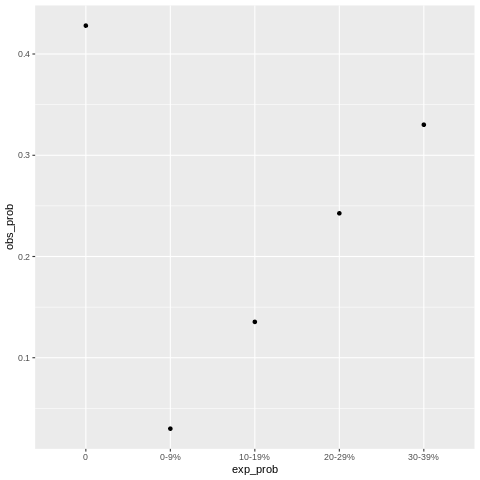

In [ ]:
#Make Reliability Chart

%%R

x2 <- model.matrix(ppm~., test_set)[,-1]
y2 <- as.numeric(test_set$ppm)-1
probs <- lasso.model %>% predict(newx = x2, type = "response")
calib_data <- cbind(y2, probs)
calib_data <- as_tibble(calib_data)
calib_data <- calib_data %>% rename(ppm = y2, prob = s0)
calib_data <- calib_data %>% arrange(desc(prob))

calib_data$exp_prob <- 0
for (i in 1:nrow(calib_data)){
  if(calib_data$prob[i] < 0.1)
    calib_data$exp_prob[i] <- "0-9%"
}
for (i in 1:nrow(calib_data)){
  if(calib_data$prob[i] >= 0.1 & calib_data$prob[i] < 0.2)
    calib_data$exp_prob[i] <- "10-19%"
}
for (i in 1:nrow(calib_data)){
  if(calib_data$prob[i] >= 0.2 & calib_data$prob[i] < 0.3)
    calib_data$exp_prob[i] <- "20-29%"
}
for (i in 1:nrow(calib_data)){
  if(calib_data$prob[i] >= 0.3 & calib_data$prob[i] < 0.4)
    calib_data$exp_prob[i] <- "30-39%"
}

calib_data <- calib_data %>% group_by(exp_prob) %>% summarise(obs_prob = mean(prob))

calib_data %>%
  ggplot() +
  geom_point(aes(x = exp_prob, y = obs_prob))

In [ ]:
# Spiegalhalter Z

%%R

Spiegelhalter_z = function(y, prob){
  alpha = 0.05
  z_score = sum((y-prob)*(1-2*prob))/sqrt(sum(((1-2*prob)^2)*prob*(1-prob)))
  print(z_score)
  if (abs(z_score) > qnorm(1-alpha/2)){
    print('reject null. NOT calibrated')
  } else{
    print('fail to reject. calibrated')
  }
  cat('z score: ', z_score, '\n')
  cat('p value: ', 1-pnorm(abs(z_score)), '\n')
  return(z_score)
}

probs <- as.vector(probs)
Spiegelhalter_z(y = y2, prob = probs)

[1] -521.3591
[1] "reject null. NOT calibrated"
z score:  -521.3591 
p value:  0 
[1] -521.3591
